For this question, the main work is to derive the posterior distribution for each of the four possible states as we do not explicitly keep track of $X_t$ values. 

The likelihood computation involved in the weight update given on step (c) on pg 890, requires computing predictive likelihood $p(y_t | y_{\tau:t-1})$ when $S_t = 1$.

We are given $\sigma=10000$, $\tau_1 = 2500$ and $\tau_2 = 12500$ and $\mu = 115000$, $\nu = 85000$. 

We will use 100 as the maximum number of particles.

# Posterior update

## Case 1: $S_t = 2$ and $O_t = 1$.

In this case, we have a new change point. So we set $\tau = t$.

And the posterior distribution is given by

$$p(x_t | y_t) = \frac{p(y_t | x_t) p(x_t)}{p(y_t)}.$$

Since we have Normal prior $X_t \sim \text{Normal}(\mu, \sigma^2)$ and Normal likelihood $Y_t | X_t = x\sim \text{Normal}(x, \tau_1^2)$, we have conjugacy.

We are given the values of $\sigma, \tau_1$, so we fall in the case of Normal distribution with unknown $\mu$ but known variance (see [Wikipedia](https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution)).

The posterior update with sufficient statistic $\phi_t = y_t$:

\begin{align*}
    \gamma_t^2 &= \left( \frac{1}{\sigma^2} + \frac{1}{\tau_1^2} \right)^{-1} \\
    \alpha_t &= \gamma_t^2 \left(\frac{\mu}{\sigma^2} + \frac{\phi_t}{\tau_1^2} \right)
\end{align*}

## Case 2: $S_t = 1$ and $O_t = 1$.

Let $\tau < t$ be the time of last change point. The posterior distribution in this case is given by

\begin{align*}
    p(x_t | y_{\tau:t}) = \frac{p(y_t | x_t) p(x_t | y_{\tau:t-1})}{p(y_t | y_{\tau:t-1})}.
\end{align*}

Note that $p(x_t | y_{\tau:t-1})$ denotes the predictive distribution but can also be seen as an updated prior after seeing $\tau:t-1$ data points. 

\begin{align*}
  p(x_t | y_{\tau:t-1}) &= \int p(x_t | x_{t-1}) p(x_{t-1} | y_{\tau:t-1}) dx_{t-1} \\
  &= p(x_{t-1} | y_{\tau:t-1}).
\end{align*}

since $s_t = 1$, we have $p(x_t | x_{t-1}) = 1[x_t = x_{t-1}]$. 

By induction (or recursion argument), we can see that $p(x_{t-1} | y_{\tau:t-1})$ is Normal distribution (the base case given in Case 1 above for $s_t = 2, o_t=1$) with mean and variance given by,

\begin{align*}
    \gamma_{t-1}^2 &= \left( \frac{1}{\sigma^2} + \frac{t - \tau}{\tau_1^2} \right)^{-1} \\
    \alpha_{t-1} &= \gamma_t^2 \left(\frac{\mu}{\sigma^2} + \frac{\phi_{t-1}}{\tau_1^2} \right),
\end{align*}

with sufficient statistic $\phi_{t-1} = \sum_{i=\tau}^{t-1} y_i$. 

Keeping track of the sufficient statistic is recommended for computational efficiency. Given $\phi_{t-1}$, we just need $O(1)$ computation to update the sufficient stat at time $t$: $\phi_{t} = \phi_{t-1} + y_t$. 

With $x_t | y_{\tau:t-1} \sim N(\alpha_{t-1}, \gamma_{t-1}^2)$ as prior and $y_t | x_t \sim \text{Normal}(x_t, \tau_1^2)$, we obtain the following update:

\begin{align*}
    \gamma_t^2 &= \left( \frac{1}{\sigma^2} + \frac{t - \tau + 1}{\tau_1^2} \right)^{-1} \\
    \alpha_t &= \gamma_t^2 \left(\frac{\mu}{\sigma^2} + \frac{\phi_t}{\tau_1^2} \right)
\end{align*}

## Case 3: $S_t = 1$ and $O_t = 2$.

We have a new change point so we set $\tau = t$, but the observation is an outlier. In this case, the posterior is unchanged from the previous time point:

$$p(x_t | y_{\tau:t}) = p(x_t | y_{\tau:t-1}).$$

This is because when $O_t = 2$, the value of $y_t$ is independent of $x_t$:

\begin{align*}
    p(x_t | y_{\tau:t}) &= \frac{p(y_t | x_t) p(x_t | y_{\tau:t-1})}{\int p(y_t | x_t) p(x_t | y_{\tau:t-1})dx_t}  \\
    &= \frac{p(y_t) p(x_t | y_{\tau:t-1})}{p(y_t)} \\
    &= p(x_{t-1} | y_{\tau:t-1}),
\end{align*}

where the last line is because $x_t = x_{t-1}$ since $S_t = 1$.

## Case 4: $S_t = 2$ and $O_t = 2$.

We again have a new change point so we set $\tau = t$, but the observation is an outlier. In this case, the posterior is equal to the prior:

$$p(x_t | y_t) = p(x_t) = \text{Normal}(\mu, \sigma^2).$$

# Predictive likelihood

## $S_t = 1$ and $O_t = 1$.

We have $x_t | y_{\tau:t-1} \sim \text{Normal}(\alpha_{t-1}, \gamma_{t-1}^2)$ and $y_t | x_t \sim \text{Normal}(x_t, \tau_1^2)$. The predictive is 

$$\text{Normal}(\alpha_{t-1}, \gamma_{t-1}^2 + \tau_1^2).$$

## $S_t = 2$ and $O_t = 1$.

$$\text{Normal}(\mu, \sigma^2 + \tau_1^2).$$


In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [2]:
from problem2 import *

In [3]:
well_data = pd.read_csv("welldata.csv", header=None)
Y = well_data.to_numpy()[:,0]
T = len(Y)

In [4]:
#pyplot.scatter(np.arange(len(Y)), Y)

In [8]:
max_particles = 100
mu = 115000
sigma = 10000
nu = 85000
tau_1 = 2500
tau_2 = 12500
cp_prob = 1./250

tt = T # set it to a small number for test stage.
pops = run_pf(Y[0:tt], max_particles, mu, sigma, nu, tau_1, tau_2, cp_prob)


Iteration 0.
Iteration 1.
Iteration 2.
Iteration 3.
# of particles to sample:5, stratum length:3.213537184821765e-15, uniform:6.589803336118542e-16
Iteration 4.
# of particles to sample:16, stratum length:7.530775095783549e-13, uniform:4.127811415636984e-13
Iteration 5.
# of particles to sample:14, stratum length:3.2048872708890573e-10, uniform:1.7929446396753445e-10
Iteration 6.
# of particles to sample:23, stratum length:6.190555670133504e-08, uniform:5.6780612262470324e-08
Iteration 7.
# of particles to sample:27, stratum length:1.1019576698178288e-06, uniform:5.204734821846655e-07
Iteration 8.
# of particles to sample:30, stratum length:3.577537488739794e-05, uniform:4.941836534423923e-06
Iteration 9.
# of particles to sample:24, stratum length:0.00010944898975656193, uniform:7.487286132666087e-05
Iteration 10.
# of particles to sample:46, stratum length:0.00026845338718814286, uniform:1.434274904615758e-07
Iteration 11.
# of particles to sample:20, stratum length:0.000169541666998

In [9]:
outlier_probs = []
changepoint_probs = []
for t in range(tt):
    pop = pops[t]
    outlier_prob = 0.
    changepoint_prob = 0.
    for n in range(pop.size()):
        state, weight = pop.at(n)
        if state.o == 2:
            outlier_prob += weight
        if state.s == 2:
            changepoint_prob += weight
    outlier_probs.append(outlier_prob)
    changepoint_probs.append(changepoint_prob)

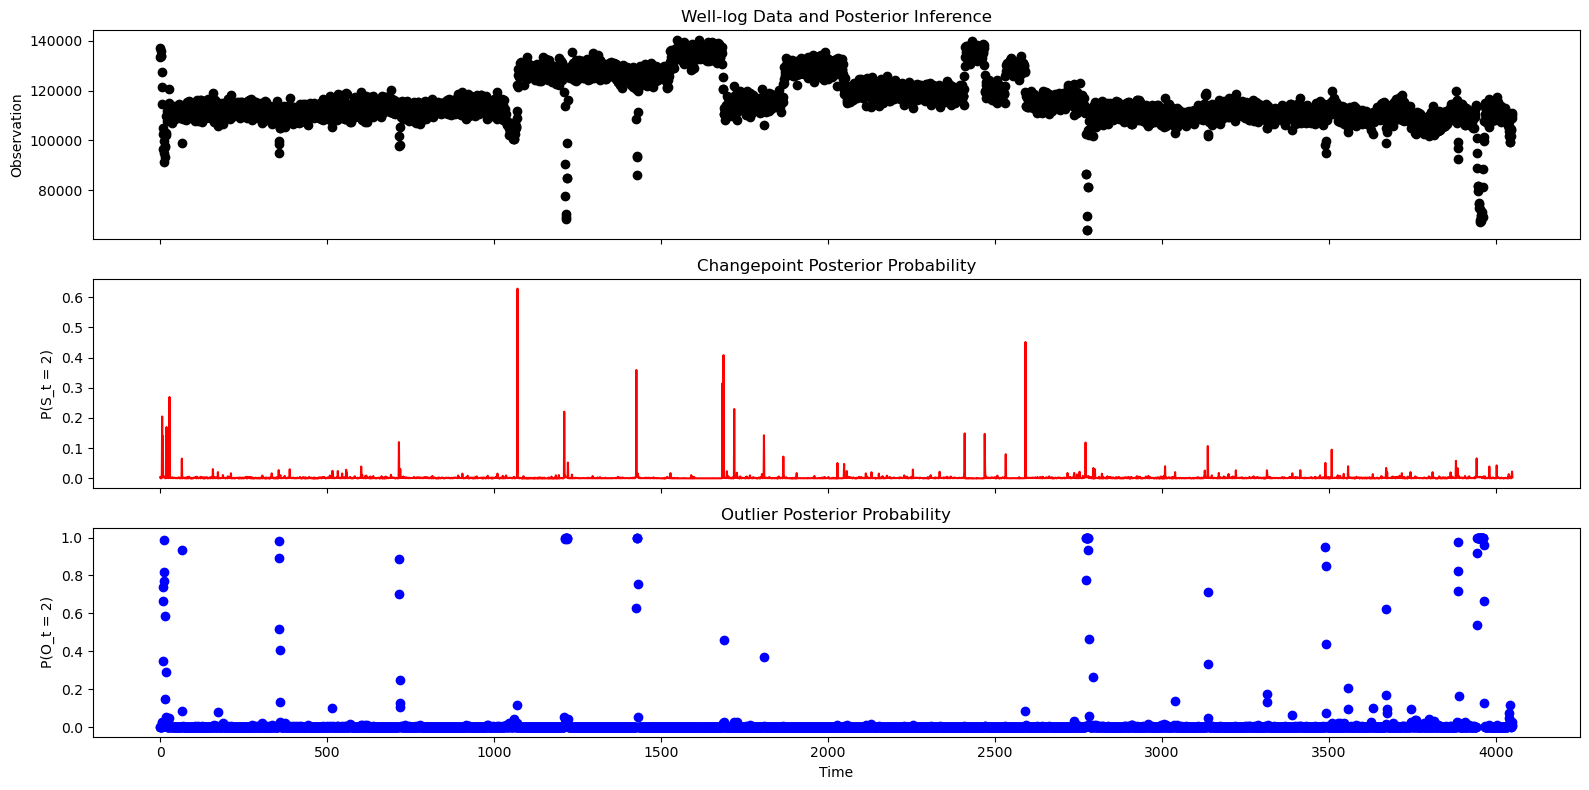

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)

# Panel 1: Observations
axes[0].scatter(range(tt), Y[:tt], color='black')
axes[0].set_ylabel("Observation")
axes[0].set_title("Well-log Data and Posterior Inference")

# Panel 2: Changepoint posterior
axes[1].plot(changepoint_probs, color='red')
axes[1].set_ylabel("P(S_t = 2)")
axes[1].set_title("Changepoint Posterior Probability")

# Panel 3: Outlier posterior
axes[2].scatter(range(tt), outlier_probs, color='blue')
axes[2].set_ylabel("P(O_t = 2)")
axes[2].set_xlabel("Time")
axes[2].set_title("Outlier Posterior Probability")

plt.tight_layout()
plt.savefig("well_log_three_panel_plot.png", dpi=300)
plt.show()